In [132]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, MarkerCluster
from branca.element import Element
from pathlib import Path
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    RocCurveDisplay,
    roc_auc_score,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams.update({'figure.figsize': (10, 6), 'axes.titlesize': 14, 'axes.titleweight': 'bold'})
pd.options.display.max_columns = 60
def resolve_data_path(filename='CrimeDataLAPD.parquet'):
    search_roots = [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]
    for root in search_roots:
        candidate = root / 'Data' / filename
        if candidate.exists():
            return candidate
    raise FileNotFoundError('CrimeDataLAPD.parquet not found. Adjust resolve_data_path search logic.')
DATA_PATH = resolve_data_path()
RANDOM_STATE = 42
DATA_PATH

PosixPath('/Users/gaurabh/ADS/LAPD/LAPDCrimeDataAnalysis/Data/CrimeDataLAPD.parquet')

In [133]:
df_raw = pd.read_parquet(DATA_PATH)
print(f'Records: {df_raw.shape[0]:,}  |  Columns: {df_raw.shape[1]}')
df_raw.head()

Records: 1,004,991  |  Columns: 28


DR_NO  Date Rptd   DATE OCC  TIME OCC  AREA    AREA NAME  Rpt Dist No  \
0  211507896 2021-04-11 2020-11-07  08:45:00    15  N Hollywood         1502   
1  201516622 2020-10-21 2020-10-18  18:45:00    15  N Hollywood         1521   
2  240913563 2024-12-10 2020-10-30  12:40:00     9     Van Nuys          933   
3  210704711 2020-12-24 2020-12-24  13:10:00     7     Wilshire          782   
4  201418201 2020-10-03 2020-09-29  18:30:00    14      Pacific         1454   

   Part 1-2  Crm Cd                                        Crm Cd Desc  \
0         2     354                                  THEFT OF IDENTITY   
1         1     230     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT   
2         2     354                                  THEFT OF IDENTITY   
3         1     331  THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...   
4         1     420    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)   

                                   Mocodes  Vict Age Vict Sex  \
0                                     0377        31     Male   
1  0416 0334 2004 1822 1414 0305 0319 0400        32     Male   
2                                     0377        30     Male   
3                                     0344        47   Female   
4                      1300 0344 1606 2032        63     Male   

             Vict Descent  Premis Cd             Premis Desc  Weapon Used Cd  \
0  Hispanic/Latin/Mexican      501.0  SINGLE FAMILY DWELLING             0.0   
1  Hispanic/Latin/Mexican      102.0                SIDEWALK           200.0   
2                   White      501.0  SINGLE FAMILY DWELLING             0.0   
3             Other Asian      101.0                  STREET             0.0   
4  Hispanic/Latin/Mexican      103.0                   ALLEY             0.0   

                        Weapon Desc Status  Status Desc  Crm Cd 1  \
0                           Unknown     IC  Invest Cont     354.0   
1  KNIFE WITH BLADE 6INCHES OR LESS     IC  Invest Cont     230.0   
2                           Unknown     IC  Invest Cont     354.0   
3                           Unknown     IC  Invest Cont     331.0   
4                           Unknown     IC  Invest Cont     420.0   

                                   LOCATION      LAT       LON  occ_year  \
0   7800    BEEMAN                       AV  34.2124 -118.4092      2020   
1           ATOLL                        AV  34.1993 -118.4203      2020   
2  14600    SYLVAN                       ST  34.1847 -118.4509      2020   
3   6000    COMEY                        AV  34.0339 -118.3747      2020   
4                   4700    LA VILLA MARINA  33.9813 -118.4350      2020   

  occ_month  occ_date occ_day  
0       Nov         7     Sat  
1       Oct        18     Sun  
2       Oct        30     Fri  
3       Dec        24     Thu  
4       Sep        29     Tue

In [134]:
row_count, col_count = df_raw.shape
missing_summary = (
    pd.DataFrame({
        'dtype': df_raw.dtypes.astype(str),
        'missing_pct': (df_raw.isna().mean() * 100).round(2),
        'unique_values': df_raw.nunique(dropna=False)
    })
    .sort_values('missing_pct', ascending=False)
)
missing_summary

dtype  missing_pct  unique_values
DR_NO                    int64          0.0        1004991
Date Rptd       datetime64[ns]          0.0           1896
occ_date                 int32          0.0             31
occ_month               object          0.0             12
occ_year                 int32          0.0              6
LON                    float64          0.0           4982
LAT                    float64          0.0           5426
LOCATION                object          0.0          66566
Crm Cd 1               float64          0.0            143
Status Desc             object          0.0              6
Status                  object          0.0              7
Weapon Desc             object          0.0             80
Weapon Used Cd         float64          0.0             80
Premis Desc             object          0.0            307
Premis Cd              float64          0.0            315
Vict Descent            object          0.0             20
Vict Sex                object          0.0              4
Vict Age                 int64          0.0            104
Mocodes                 object          0.0         310941
Crm Cd Desc             object          0.0            140
Crm Cd                   int64          0.0            140
Part 1-2                 int64          0.0              2
Rpt Dist No              int64          0.0           1210
AREA NAME               object          0.0             21
AREA                     int64          0.0             21
TIME OCC                object          0.0           1439
DATE OCC        datetime64[ns]          0.0           1879
occ_day                 object          0.0              7

In [135]:
numeric_summary = df_raw.select_dtypes(include='number').describe().transpose()
numeric_summary

count          mean           std        min  \
DR_NO           1004991.0  2.202215e+08  1.319718e+07   817.0000   
AREA            1004991.0  1.069174e+01  6.110255e+00     1.0000   
Rpt Dist No     1004991.0  1.115633e+03  6.111605e+02   101.0000   
Part 1-2        1004991.0  1.400348e+00  4.899691e-01     1.0000   
Crm Cd          1004991.0  5.001568e+02  2.052731e+02   110.0000   
Vict Age        1004991.0  2.891706e+01  2.199272e+01    -4.0000   
Premis Cd       1004991.0  3.056153e+02  2.193038e+02     0.0000   
Weapon Used Cd  1004991.0  1.185118e+02  1.845896e+02     0.0000   
Crm Cd 1        1004991.0  4.999119e+02  2.050791e+02     0.0000   
LAT             1004991.0  3.399821e+01  1.610713e+00     0.0000   
LON             1004991.0 -1.180909e+02  5.582386e+00  -118.6676   
occ_year        1004991.0  2.021879e+03  1.315051e+00  2020.0000   
occ_date        1004991.0  1.534594e+01  8.950559e+00     1.0000   

                         25%           50%           75%           max  
DR_NO           2.106169e+08  2.209159e+08  2.311103e+08  2.521041e+08  
AREA            5.000000e+00  1.100000e+01  1.600000e+01  2.100000e+01  
Rpt Dist No     5.870000e+02  1.139000e+03  1.613000e+03  2.199000e+03  
Part 1-2        1.000000e+00  1.000000e+00  2.000000e+00  2.000000e+00  
Crm Cd          3.310000e+02  4.420000e+02  6.260000e+02  9.560000e+02  
Vict Age        0.000000e+00  3.000000e+01  4.400000e+01  1.200000e+02  
Premis Cd       1.010000e+02  2.030000e+02  5.010000e+02  9.760000e+02  
Weapon Used Cd  0.000000e+00  0.000000e+00  3.070000e+02  5.160000e+02  
Crm Cd 1        3.310000e+02  4.420000e+02  6.260000e+02  9.560000e+02  
LAT             3.401470e+01  3.405890e+01  3.416490e+01  3.433430e+01  
LON            -1.184305e+02 -1.183225e+02 -1.182739e+02  0.000000e+00  
occ_year        2.021000e+03  2.022000e+03  2.023000e+03  2.025000e+03  
occ_date        7.000000e+00  1.500000e+01  2.300000e+01  3.100000e+01

In [136]:
categorical_summary = (
    df_raw.select_dtypes(include='object')
    .nunique()
    .sort_values(ascending=False)
    .to_frame('unique_values')
)
categorical_summary.head(12)

unique_values
Mocodes              310941
LOCATION              66566
TIME OCC               1439
Premis Desc             307
Crm Cd Desc             140
Weapon Desc              80
AREA NAME                21
Vict Descent             20
occ_month                12
Status                    7
occ_day                   7
Status Desc               6

In [137]:
df_clean = df_raw.copy()
df_clean = df_clean[df_clean['DATE OCC'].notna()].copy()
df_clean = df_clean.drop_duplicates(subset='DR_NO')
df_clean = df_clean[df_clean['Vict Age'].between(0, 110)]
df_clean['TIME OCC'] = pd.to_datetime(df_clean['TIME OCC'], format='%H:%M:%S', errors='coerce')
df_clean['occ_hour'] = df_clean['TIME OCC'].dt.hour
df_clean['occ_minute'] = df_clean['TIME OCC'].dt.minute
df_clean['occ_weekday'] = df_clean['DATE OCC'].dt.day_name()
df_clean['occ_month_start'] = df_clean['DATE OCC'].dt.to_period('M').dt.to_timestamp()
df_clean['occ_year'] = df_clean['DATE OCC'].dt.year
df_clean['occ_month_name'] = df_clean['DATE OCC'].dt.strftime('%b')
df_clean['occ_day_of_month'] = df_clean['DATE OCC'].dt.day
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_clean['occ_weekday'] = pd.Categorical(df_clean['occ_weekday'], categories=weekday_order, ordered=True)
df_clean['is_weekend'] = df_clean['occ_weekday'].isin(['Saturday', 'Sunday']).astype(int)
df_clean['is_overnight'] = df_clean['occ_hour'].isin(list(range(0, 6)) + list(range(22, 24))).astype(int)
tf_age_bins = [0, 13, 18, 30, 45, 60, 80, 120]
age_labels = ['Child (0-12)', 'Teen (13-17)', 'Young Adult (18-29)', 'Adult 30-44', 'Adult 45-59', 'Senior 60-79', '80+']
df_clean['vict_age_group'] = pd.cut(df_clean['Vict Age'], bins=tf_age_bins, labels=age_labels, right=False)
df_clean['vict_sex_clean'] = df_clean['Vict Sex'].fillna('Unknown').replace({'Transgender/Other': 'Trans / Non-binary'})
df_clean['vict_descent_clean'] = df_clean['Vict Descent'].fillna('Unknown')
df_clean['AREA NAME'] = df_clean['AREA NAME'].fillna('Unknown Area')
top_premis = df_clean['Premis Desc'].value_counts().nlargest(15).index
df_clean['premis_group'] = (
    df_clean['Premis Desc']
    .where(df_clean['Premis Desc'].isin(top_premis), 'Other/Unknown')
    .fillna('Other/Unknown')
)
df_clean['violent_crime'] = (df_clean['Part 1-2'] == 1).astype(int)
df_clean['weapon_present'] = (df_clean['Weapon Used Cd'] > 0).astype(int)
df_clean['has_location'] = df_clean[['LAT', 'LON']].notna().all(axis=1).astype(int)
print(f'Records after quality filters: {df_clean.shape[0]:,}')
df_clean.head()

Records after quality filters: 1,004,853


DR_NO  Date Rptd   DATE OCC            TIME OCC  AREA    AREA NAME  \
0  211507896 2021-04-11 2020-11-07 1900-01-01 08:45:00    15  N Hollywood   
1  201516622 2020-10-21 2020-10-18 1900-01-01 18:45:00    15  N Hollywood   
2  240913563 2024-12-10 2020-10-30 1900-01-01 12:40:00     9     Van Nuys   
3  210704711 2020-12-24 2020-12-24 1900-01-01 13:10:00     7     Wilshire   
4  201418201 2020-10-03 2020-09-29 1900-01-01 18:30:00    14      Pacific   

   Rpt Dist No  Part 1-2  Crm Cd  \
0         1502         2     354   
1         1521         1     230   
2          933         2     354   
3          782         1     331   
4         1454         1     420   

                                         Crm Cd Desc  \
0                                  THEFT OF IDENTITY   
1     ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT   
2                                  THEFT OF IDENTITY   
3  THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...   
4    THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)   

                                   Mocodes  Vict Age Vict Sex  \
0                                     0377        31     Male   
1  0416 0334 2004 1822 1414 0305 0319 0400        32     Male   
2                                     0377        30     Male   
3                                     0344        47   Female   
4                      1300 0344 1606 2032        63     Male   

             Vict Descent  Premis Cd             Premis Desc  Weapon Used Cd  \
0  Hispanic/Latin/Mexican      501.0  SINGLE FAMILY DWELLING             0.0   
1  Hispanic/Latin/Mexican      102.0                SIDEWALK           200.0   
2                   White      501.0  SINGLE FAMILY DWELLING             0.0   
3             Other Asian      101.0                  STREET             0.0   
4  Hispanic/Latin/Mexican      103.0                   ALLEY             0.0   

                        Weapon Desc Status  Status Desc  Crm Cd 1  \
0                           Unknown     IC  Invest Cont     354.0   
1  KNIFE WITH BLADE 6INCHES OR LESS     IC  Invest Cont     230.0   
2                           Unknown     IC  Invest Cont     354.0   
3                           Unknown     IC  Invest Cont     331.0   
4                           Unknown     IC  Invest Cont     420.0   

                                   LOCATION      LAT       LON  occ_year  \
0   7800    BEEMAN                       AV  34.2124 -118.4092      2020   
1           ATOLL                        AV  34.1993 -118.4203      2020   
2  14600    SYLVAN                       ST  34.1847 -118.4509      2020   
3   6000    COMEY                        AV  34.0339 -118.3747      2020   
4                   4700    LA VILLA MARINA  33.9813 -118.4350      2020   

  occ_month  occ_date occ_day  occ_hour  occ_minute occ_weekday  \
0       Nov         7     Sat         8          45    Saturday   
1       Oct        18     Sun        18          45      Sunday   
2       Oct        30     Fri        12          40      Friday   
3       Dec        24     Thu        13          10    Thursday   
4       Sep        29     Tue        18          30     Tuesday   

  occ_month_start occ_month_name  occ_day_of_month  is_weekend  is_overnight  \
0      2020-11-01            Nov                 7           1             0   
1      2020-10-01            Oct                18           1             0   
2      2020-10-01            Oct                30           0             0   
3      2020-12-01            Dec                24           0             0   
4      2020-09-01            Sep                29           0             0   

  vict_age_group vict_sex_clean      vict_descent_clean  \
0    Adult 30-44           Male  Hispanic/Latin/Mexican   
1    Adult 30-44           Male  Hispanic/Latin/Mexican   
2    Adult 30-44           Male                   White   
3    Adult 45-59         Female             Other Asian   
4   Senior 60-79           Male  Hispanic/Latin/Mexican   

       

In [138]:
kpi_rows = [
    ('Incidents retained', f"{len(df_clean):,}"),
    ('Part I (violent/serious) share', f"{df_clean['violent_crime'].mean():.1%}"),
    ('Unique reporting areas', df_clean['AREA NAME'].nunique()),
    ('Unique crime descriptions', df_clean['Crm Cd Desc'].nunique()),
    ('Median victim age', f"{df_clean['Vict Age'].median():.0f} years"),
    ('Weapon recorded', f"{df_clean['weapon_present'].mean():.1%} of incidents"),
    ('Latitude/longitude present', f"{df_clean['has_location'].mean():.1%} of incidents"),
]
pd.DataFrame(kpi_rows, columns=['Metric', 'Value'])

Metric                Value
0              Incidents retained            1,004,853
1  Part I (violent/serious) share                60.0%
2          Unique reporting areas                   21
3       Unique crime descriptions                  140
4               Median victim age             30 years
5                 Weapon recorded   32.6% of incidents
6      Latitude/longitude present  100.0% of incidents

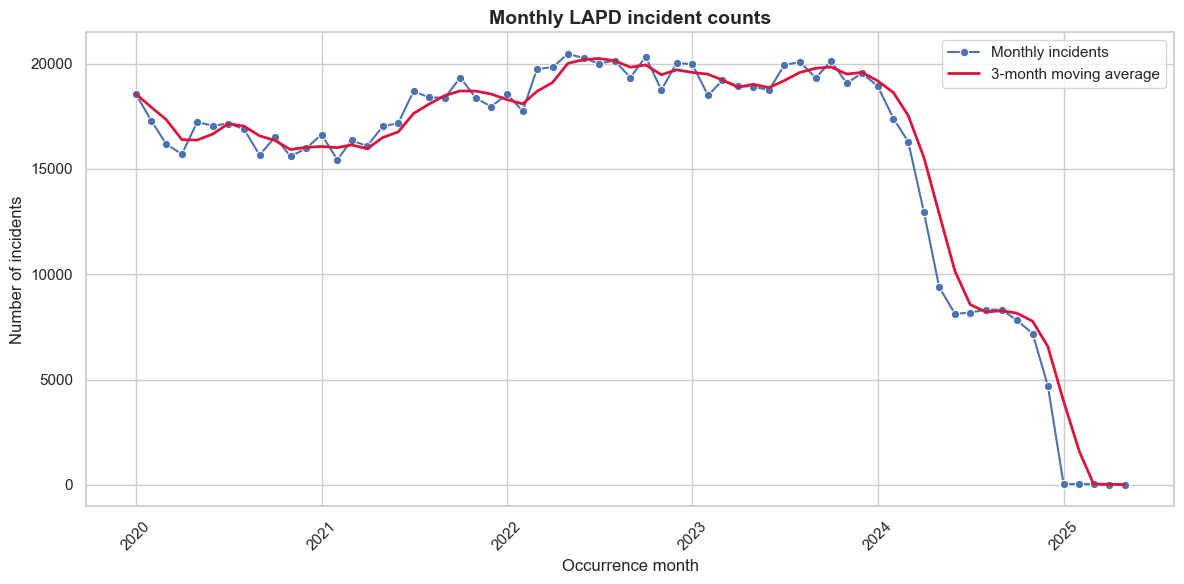

occ_month_start  incidents   rolling_3m
60      2025-01-01         26  3967.333333
61      2025-02-01         44  1589.000000
62      2025-03-01         24    31.333333
63      2025-04-01          1    23.000000
64      2025-05-01          2     9.000000

In [139]:
monthly_counts = (
    df_clean.groupby('occ_month_start')
    .size()
    .reset_index(name='incidents')
    .sort_values('occ_month_start')
)
monthly_counts['rolling_3m'] = monthly_counts['incidents'].rolling(3, min_periods=1).mean()
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='occ_month_start', y='incidents', marker='o', label='Monthly incidents', ax=ax)
sns.lineplot(data=monthly_counts, x='occ_month_start', y='rolling_3m', label='3-month moving average', ax=ax, color='crimson', linewidth=2)
ax.set_title('Monthly LAPD incident counts')
ax.set_xlabel('Occurrence month')
ax.set_ylabel('Number of incidents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
monthly_counts.tail()

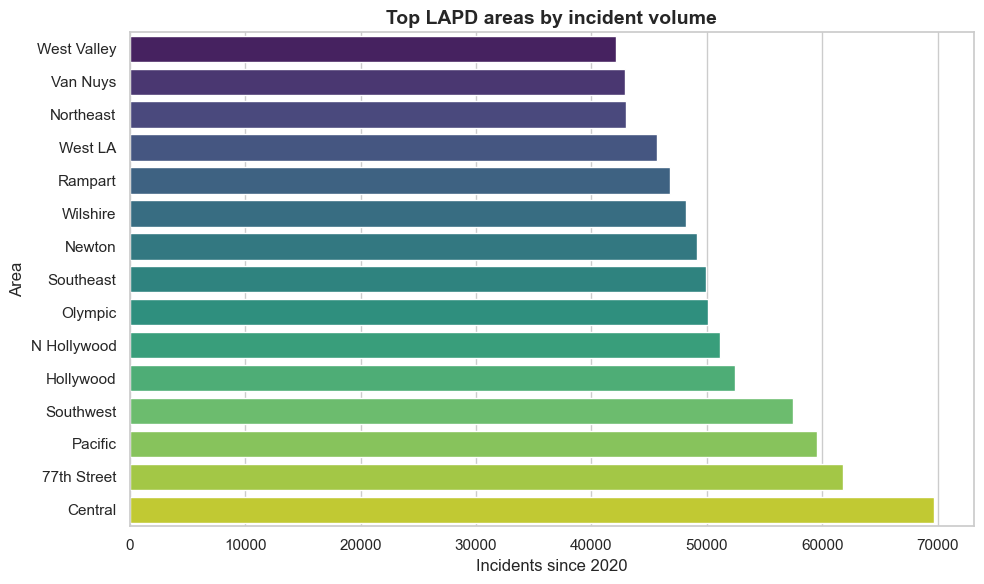

AREA NAME  incidents
14      Central      69656
13  77th Street      61757
12      Pacific      59508
11    Southwest      57440
10    Hollywood      52423

In [140]:
area_counts = (
    df_clean['AREA NAME']
    .value_counts()
    .head(15)
    .sort_values(ascending=True)
    .reset_index(name='incidents')
    .rename(columns={'index': 'AREA NAME'})
)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=area_counts, x='incidents', y='AREA NAME', palette='viridis', ax=ax)
ax.set_title('Top LAPD areas by incident volume')
ax.set_xlabel('Incidents since 2020')
ax.set_ylabel('Area')
plt.tight_layout()
plt.show()
area_counts.sort_values('incidents', ascending=False).head()

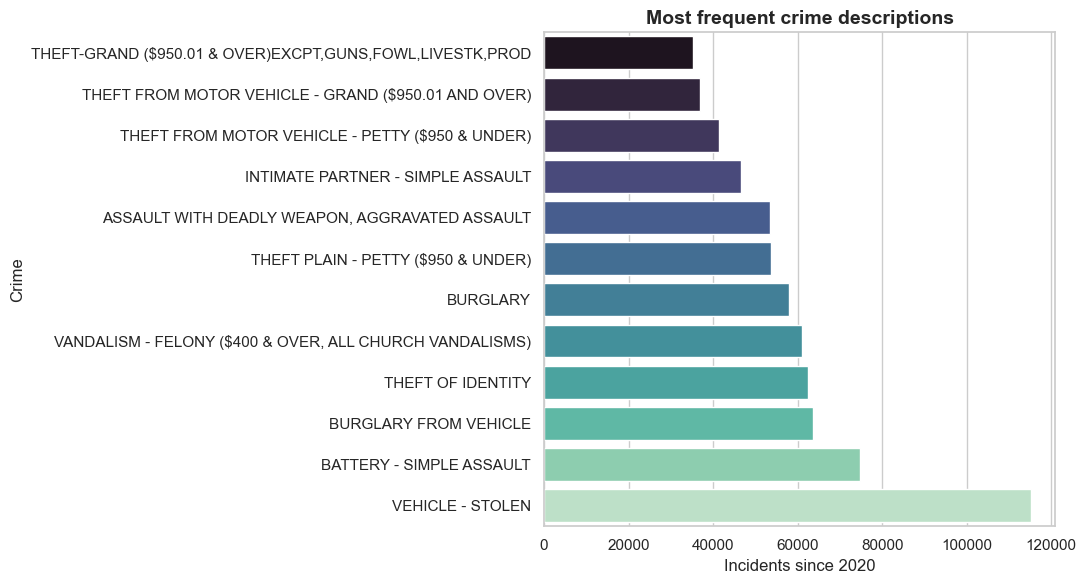

Crm Cd Desc  incidents
11                                   VEHICLE - STOLEN     115189
10                           BATTERY - SIMPLE ASSAULT      74839
9                               BURGLARY FROM VEHICLE      63517
8                                   THEFT OF IDENTITY      62522
7   VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...      61076
6                                            BURGLARY      57864
5                  THEFT PLAIN - PETTY ($950 & UNDER)      53704
4      ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT      53524
3                   INTIMATE PARTNER - SIMPLE ASSAULT      46711
2     THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)      41314
1   THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...      36939
0   THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...      35139

In [141]:
top_crimes = (
    df_clean['Crm Cd Desc']
    .value_counts()
    .head(12)
    .sort_values(ascending=True)
    .reset_index(name='incidents')
    .rename(columns={'index': 'Crm Cd Desc'})
)
fig, ax = plt.subplots(figsize=(11, 6))
sns.barplot(data=top_crimes, x='incidents', y='Crm Cd Desc', palette='mako', ax=ax)
ax.set_title('Most frequent crime descriptions')
ax.set_xlabel('Incidents since 2020')
ax.set_ylabel('Crime')
plt.tight_layout()
plt.show()
top_crimes.sort_values('incidents', ascending=False)

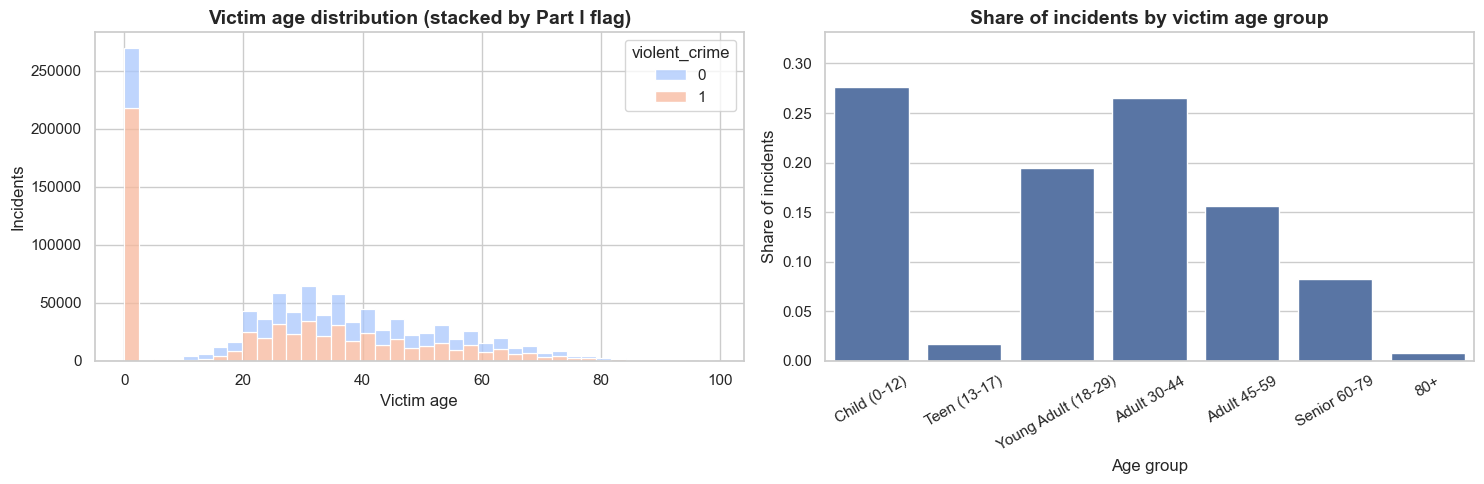

Age group     share
0         Child (0-12)  0.276186
1         Teen (13-17)  0.017210
2  Young Adult (18-29)  0.194897
3          Adult 30-44  0.265194
4          Adult 45-59  0.156069
5         Senior 60-79  0.082217
6                  80+  0.008227

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=df_clean, x='Vict Age', hue='violent_crime', multiple='stack', bins=40, palette='coolwarm', ax=axes[0])
axes[0].set_title('Victim age distribution (stacked by Part I flag)')
axes[0].set_xlabel('Victim age')
axes[0].set_ylabel('Incidents')
age_group_share = (
    df_clean['vict_age_group']
    .value_counts(normalize=True)
    .sort_index()
    .reset_index(name='share')
    .rename(columns={'vict_age_group': 'Age group'})
)
sns.barplot(data=age_group_share, x='Age group', y='share', color='#4C72B0', ax=axes[1])
axes[1].set_title('Share of incidents by victim age group')
axes[1].set_ylabel('Share of incidents')
axes[1].set_xlabel('Age group')
axes[1].set_ylim(0, age_group_share['share'].max() * 1.2)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
age_group_share

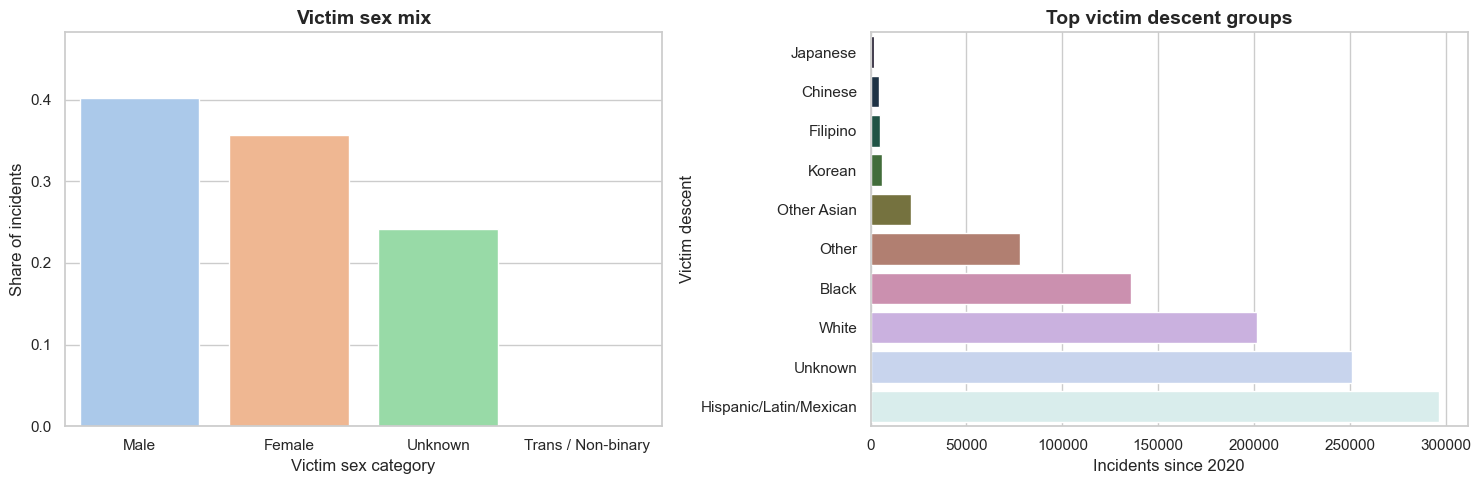

(           Victim sex     share
 0                Male  0.401903
 1              Female  0.356836
 2             Unknown  0.241148
 3  Trans / Non-binary  0.000113,
            Victim descent  incidents
 9  Hispanic/Latin/Mexican     296396
 8                 Unknown     251239
 7                   White     201422
 6                   Black     135815
 5                   Other      77999
 4             Other Asian      21339
 3                  Korean       5990
 2                Filipino       4838
 1                 Chinese       4631
 0                Japanese       1586)

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sex_counts = (
    df_clean['vict_sex_clean']
    .value_counts(normalize=True)
    .reset_index(name='share')
    .rename(columns={'vict_sex_clean': 'Victim sex'})
)
sns.barplot(data=sex_counts, x='Victim sex', y='share', palette='pastel', ax=axes[0])
axes[0].set_title('Victim sex mix')
axes[0].set_ylabel('Share of incidents')
axes[0].set_xlabel('Victim sex category')
axes[0].set_ylim(0, sex_counts['share'].max() * 1.2)
race_counts = (
    df_clean['vict_descent_clean']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)
    .reset_index(name='incidents')
    .rename(columns={'vict_descent_clean': 'Victim descent'})
)
sns.barplot(data=race_counts, x='incidents', y='Victim descent', palette='cubehelix', ax=axes[1])
axes[1].set_title('Top victim descent groups')
axes[1].set_xlabel('Incidents since 2020')
axes[1].set_ylabel('Victim descent')
plt.tight_layout()
plt.show()
sex_counts, race_counts.sort_values('incidents', ascending=False)

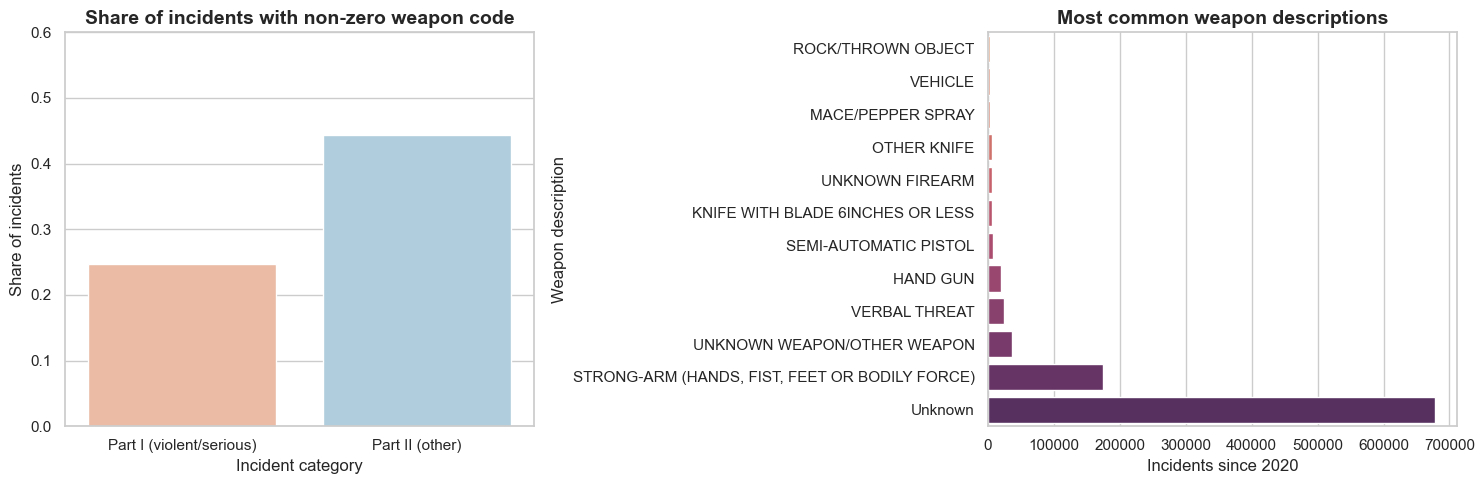

(                   severity  weapon_share
 0  Part I (violent/serious)      0.247049
 1           Part II (other)      0.443409,
                                        Weapon Desc  incidents
 11                                         Unknown     677618
 10  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)     174758
 9                      UNKNOWN WEAPON/OTHER WEAPON      36389
 8                                    VERBAL THREAT      23844
 7                                         HAND GUN      20182
 6                            SEMI-AUTOMATIC PISTOL       7266
 5                 KNIFE WITH BLADE 6INCHES OR LESS       6838
 4                                  UNKNOWN FIREARM       6581
 3                                      OTHER KNIFE       5878
 2                                MACE/PEPPER SPRAY       3730
 1                                          VEHICLE       3260
 0                               ROCK/THROWN OBJECT       2739)

In [144]:
severity_map = {1: 'Part I (violent/serious)', 0: 'Part II (other)'}
weapon_by_severity = (
    df_clean.assign(severity=df_clean['violent_crime'].map(severity_map))
    .groupby('severity')['weapon_present']
    .mean()
    .reset_index(name='weapon_share')
)
weapon_counts = (
    df_clean['Weapon Desc']
    .fillna('Unknown')
    .value_counts()
    .head(12)
    .sort_values(ascending=True)
    .reset_index(name='incidents')
    .rename(columns={'index': 'Weapon Desc'})
)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=weapon_by_severity, x='severity', y='weapon_share', palette='RdBu', ax=axes[0])
axes[0].set_title('Share of incidents with non-zero weapon code')
axes[0].set_ylabel('Share of incidents')
axes[0].set_xlabel('Incident category')
axes[0].set_ylim(0, 0.6)
sns.barplot(data=weapon_counts, x='incidents', y='Weapon Desc', palette='flare', ax=axes[1])
axes[1].set_title('Most common weapon descriptions')
axes[1].set_xlabel('Incidents since 2020')
axes[1].set_ylabel('Weapon description')
plt.tight_layout()
plt.show()
weapon_by_severity, weapon_counts.sort_values('incidents', ascending=False)

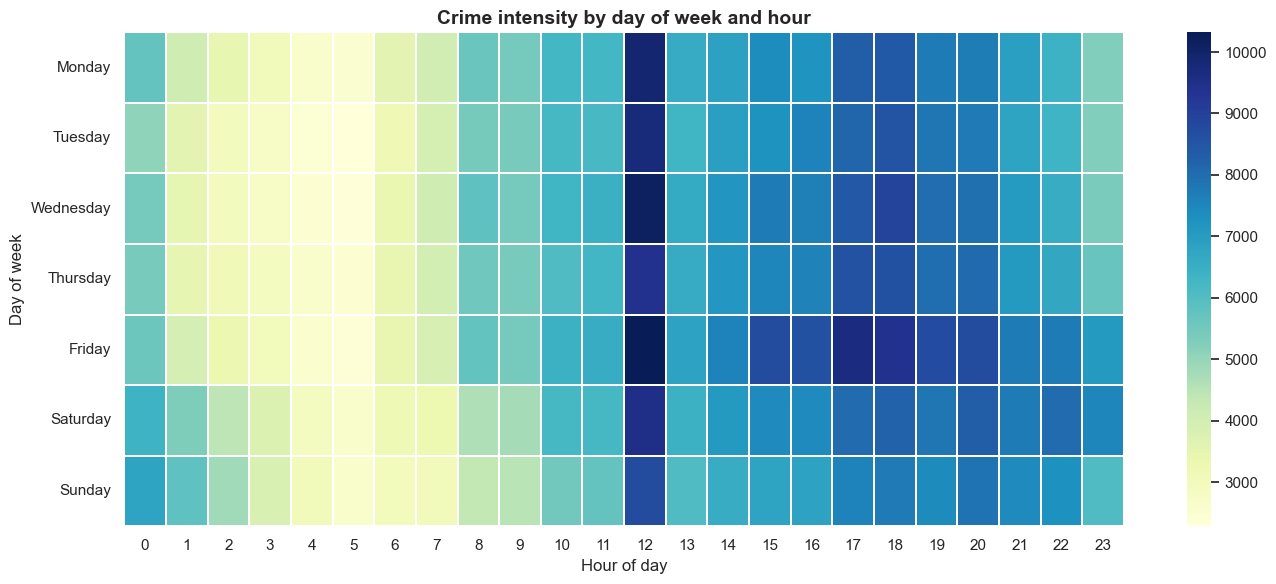

occ_hour       0     1     2     3     4     5     6     7     8     9     10  \
occ_weekday                                                                     
Monday       5719  4089  3458  3090  2605  2564  3547  4012  5671  5485  6246   
Tuesday      5101  3551  2983  2772  2458  2285  3214  3936  5442  5393  6217   
Wednesday    5461  3520  2981  2739  2495  2334  3360  4082  5815  5481  6323   
Thursday     5395  3481  3154  2944  2626  2484  3419  3995  5575  5423  6059   
Friday       5584  3978  3351  3014  2593  2399  3433  3872  5742  5462  6430   
Saturday     6366  5312  4447  3777  2912  2622  3189  3294  4659  4788  6231   
Sunday       6825  5830  4839  3854  3067  2600  3019  3071  4333  4487  5514   

occ_hour       11     12    13    14    15    16    17    18    19    20  \
occ_weekday                                                                
Monday       6247   9906  6613  6870  7375  7226  8341  8416  7737  7687   
Tuesday      6180   9754  6333  6915  7264  7589  8163  8549  7812  7751   
Wednesday    6466  10153  6647  7151  7727  7621  8467  8928  8013  7937   
Thursday     6273   9411  6598  7143  7513  7604  8587  8612  7994  8061   
Friday       6562  10320  6866  7560  8724  8622  9635  9438  8769  8739   
Saturday     6215   9507  6445  7084  7435  7451  8033  8246  7860  8290   
Sunday       5712   8739  6077  6573  6783  6859  7579  7763  7411  7882   

occ_hour       21    22    23  
occ_weekday                    
Monday       6922  6411  5288  
Tuesday      6830  6360  5268  
Wednesday    7043  6579  5364  
Thursday     7065  6695  5680  
Friday       7740  7733  7087  
Saturday     7740  8035  7507  
Sunday       7450  7289  6076

In [145]:
heatmap_data = (
    df_clean.pivot_table(index='occ_weekday', columns='occ_hour', values='DR_NO', aggfunc='count')
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    .fillna(0)
)
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.3)
plt.title('Crime intensity by day of week and hour')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')
plt.tight_layout()
plt.show()
heatmap_data

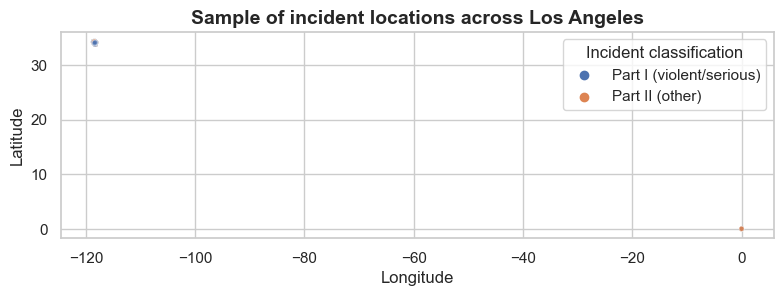

DR_NO  Date Rptd   DATE OCC            TIME OCC  AREA AREA NAME  \
769309  230113643 2023-06-05 2023-06-02 1900-01-01 10:30:00     1   Central   
865327  230815836 2023-10-20 2023-10-19 1900-01-01 19:30:00     8   West LA   
784319  230221602 2023-11-27 2023-11-27 1900-01-01 12:45:00     2   Rampart   
789176  232105087 2023-01-31 2023-01-31 1900-01-01 10:00:00    21   Topanga   
233598  212106766 2021-03-20 2021-03-19 1900-01-01 22:00:00    21   Topanga   

        Rpt Dist No  Part 1-2  Crm Cd  \
769309          111         1     341   
865327          859         2     930   
784319          271         2     930   
789176         2161         1     310   
233598         2115         2     940   

                                              Crm Cd Desc  \
769309  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...   
865327             CRIMINAL THREATS - NO WEAPON DISPLAYED   
784319             CRIMINAL THREATS - NO WEAPON DISPLAYED   
789176                                           BURGLARY   
233598                                          EXTORTION   

                    Mocodes  Vict Age Vict Sex            Vict Descent  \
769309                 0344        33     Male                  Korean   
865327            0443 1813        52   Female                   White   
784319            1822 0443        36   Female                   Black   
789176       0321 1606 1202        66     Male                   Other   
233598  0337 1817 2040 1913        26     Male  Hispanic/Latin/Mexican   

        Premis Cd                                   Premis Desc  \
769309      502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
865327      502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   
784319      102.0                                      SIDEWALK   
789176      501.0                        SINGLE FAMILY DWELLING   
233598      502.0  MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)   

        Weapon Used Cd    Weapon Desc Status   Status Desc  Crm Cd 1  \
769309             0.0        Unknown     IC   Invest Cont     341.0   
865327           511.0  VERBAL THREAT     AA  Adult Arrest     930.0   
784319           511.0  VERBAL THREAT     IC   Invest Cont     930.0   
789176             0.0        Unknown     IC   Invest Cont     310.0   
233598             0.0        Unknown     IC   Invest Cont     940.0   

                                        LOCATION      LAT       LON  occ_year  \
769309                           600 N  BROADWAY  34.0585 -118.2403      2023   
865327   1400 S  WOOSTER                      ST  34.0544 -118.3826      2023   
784319                                      10TH  34.0534 -118.2829      2023   
789176  24000    OXNARD                       ST  34.1797 -118.6495      2023   
233598   8200    OWENSMOUTH                   AV  34.2176 -118.6016      2021   

       occ_month  occ_date occ_day  occ_hour  occ_minute occ_weekday  \
769309       Jun         2     Fri        10          30      Friday   
865327       Oct        19     Thu        19          30    Thursday   
784319       Nov        27     Mon        12          45      Monday   
789176       Jan        31     Tue        10           0     Tuesday   
233598       Mar        19     Fri        22           0      Friday   

       occ_month_start occ_month_name  occ_day_of_month  is_weekend  \
769309      2023-06-01            Jun                 2           0   
865327      2023-10-01            Oct                19           0   
784319      2023-11-01            Nov                27           0   
789176      2023-01-01            Jan                31           0   
233598      2021-03-01            Mar                19           0   

        is_overnight       vict_age_group vict_sex_clean  \
769309             0          Adult 30-44           Male   
865327             0          Adult 45-59         Female   
784319             0          Adult 30-44         Female   
789176             0         Senior 60-79           Mal

In [146]:
geo_sample = (
    df_clean[df_clean['has_location'] == 1]
    .sample(n=min(6000, df_clean.shape[0]), random_state=RANDOM_STATE)
    .assign(severity=lambda d: d['violent_crime'].map({1: 'Part I (violent/serious)', 0: 'Part II (other)'}))
)
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=geo_sample, x='LON', y='LAT', hue='severity', alpha=0.5, s=12, ax=ax)
ax.set_title('Sample of incident locations across Los Angeles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal', 'box')
plt.legend(title='Incident classification', loc='upper right')
plt.tight_layout()
plt.show()
geo_sample.head()

In [147]:
map_base = df_clean[['LAT', 'LON', 'AREA NAME', 'violent_crime']].dropna()
heat_sample = map_base.sample(n=min(50000, len(map_base)), random_state=RANDOM_STATE)
cluster_sample = map_base.sample(n=min(4000, len(map_base)), random_state=RANDOM_STATE + 1)
center = [map_base['LAT'].mean(), map_base['LON'].mean()]
crime_map = folium.Map(location=center, zoom_start=11, tiles='CartoDB positron')
HeatMap(
    heat_sample[['LAT', 'LON']].values.tolist(),
    radius=12,
    blur=20,
    min_opacity=0.3,
    max_zoom=13,
    name='Density heatmap'
).add_to(crime_map)
cluster = MarkerCluster(name='Sample incidents', disableClusteringAtZoom=14).add_to(crime_map)
for _, row in cluster_sample.iterrows():
    color = 'crimson' if row['violent_crime'] == 1 else 'royalblue'
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.75,
        weight=0
    ).add_to(cluster)
legend_html = '''<div style="position: fixed; bottom: 40px; left: 40px; z-index: 9999; background-color: white; padding: 12px 16px; border-radius: 8px; box-shadow: 0 0 15px rgba(0,0,0,0.2); font-size: 14px;">
<b>Legend</b><br>
<span style="background-color: rgba(220,20,60,0.9); width: 12px; height: 12px; display: inline-block; border-radius: 50%; margin-right: 6px;"></span>Part I (violent)<br>
<span style="background-color: rgba(65,105,225,0.9); width: 12px; height: 12px; display: inline-block; border-radius: 50%; margin-right: 6px;"></span>Part II (other)<br>
</div>'''
Element(legend_html).add_to(crime_map)
folium.LayerControl(collapsed=False).add_to(crime_map)
crime_map

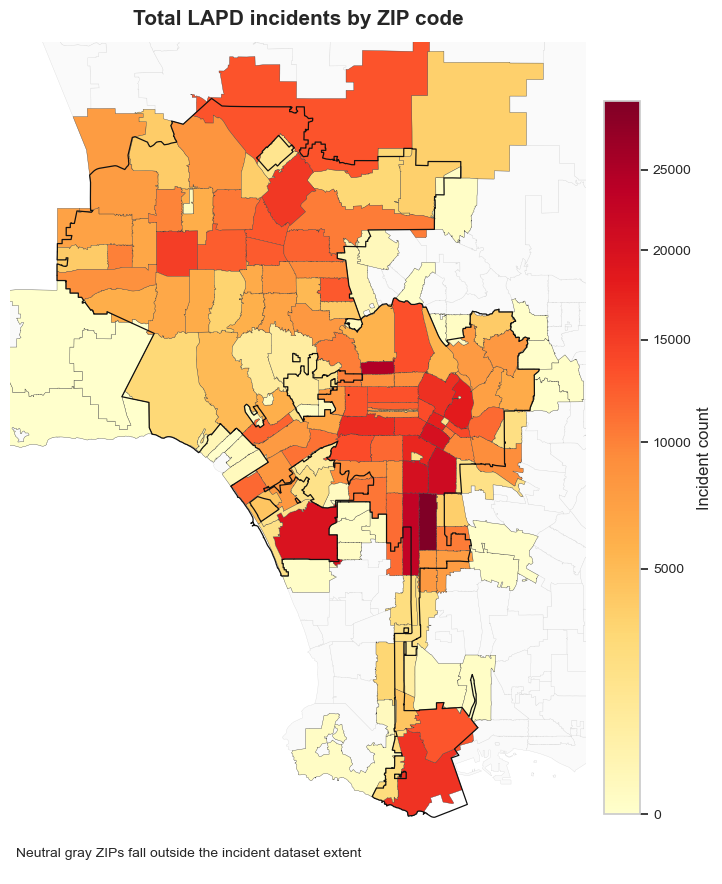

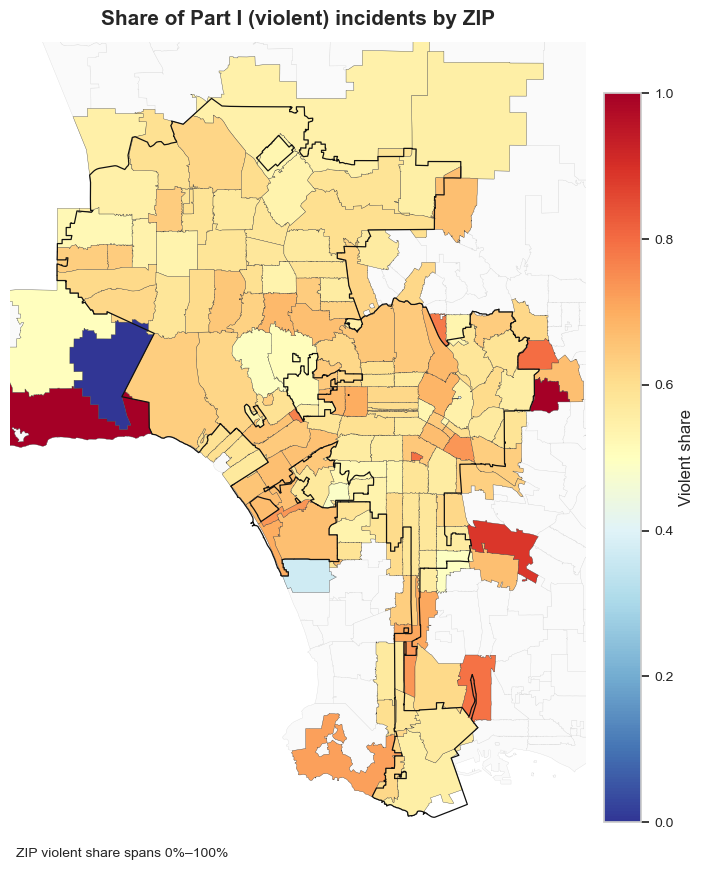

In [148]:
import geopandas as gpd
from matplotlib import colors
from pathlib import Path

zip_path = Path("../Data/LA_County_ZIP_Codes.geojson")
boundary_path = Path("../Data/City_Boundary.geojson")

zip_shapes = (
    gpd.read_file(zip_path)
    .to_crs(epsg=4326)[["ZIPCODE", "geometry"]]
    .rename(columns={"ZIPCODE": "zip_code"})
)
zip_shapes["zip_code"] = zip_shapes["zip_code"].astype(str)
boundary = gpd.read_file(boundary_path).to_crs(epsg=4326)

zip_input = (
    df_clean[["DR_NO", "violent_crime", "weapon_present", "LAT", "LON"]]
    .dropna(subset=["LAT", "LON"])
    .copy()
)
zip_points = gpd.GeoDataFrame(
    zip_input[["DR_NO", "violent_crime", "weapon_present"]],
    geometry=gpd.points_from_xy(zip_input["LON"], zip_input["LAT"]),
    crs="EPSG:4326",
)

zip_joined = gpd.sjoin(zip_points, zip_shapes, how="inner", predicate="within")
zip_summary = (
    zip_joined.groupby("zip_code")
    .agg(
        incidents=("DR_NO", "count"),
        violent_incidents=("violent_crime", "sum"),
        weapon_incidents=("weapon_present", "sum"),
    )
    .assign(
        violent_share=lambda d: d["violent_incidents"] / d["incidents"],
        weapon_share=lambda d: d["weapon_incidents"] / d["incidents"],
    )
    .reset_index()
)

zip_map = zip_shapes.merge(zip_summary, on="zip_code", how="left")
value_cols = ["incidents", "violent_incidents", "weapon_incidents", "violent_share", "weapon_share"]
zip_map[value_cols] = zip_map[value_cols].fillna(0)
zip_data = zip_map[zip_map["incidents"] > 0].copy()
if zip_data.empty:
    raise ValueError("Geo join returned no incidents inside provided ZIP shapes.")

inc_norm = colors.PowerNorm(gamma=0.6, vmin=zip_data["incidents"].min(), vmax=zip_data["incidents"].max())
violent_norm = colors.Normalize(vmin=zip_data["violent_share"].min(), vmax=zip_data["violent_share"].max())
violent_min = zip_data["violent_share"].min()
violent_max = zip_data["violent_share"].max()
city_bounds = boundary.total_bounds


def plot_zip_choropleth(ax, gdf, column, cmap, norm, title, colorbar_label):
    background = zip_map[zip_map["incidents"] == 0]
    background.plot(ax=ax, color="#fafafa", edgecolor="#d3d3d3", linewidth=0.2, zorder=0)
    gdf.plot(
        column=column,
        cmap=cmap,
        norm=norm,
        ax=ax,
        linewidth=0.25,
        edgecolor="#3f3f3f",
        zorder=1,
    )
    boundary.plot(ax=ax, facecolor="none", edgecolor="#111111", linewidth=0.9, zorder=2)
    ax.set_xlim(city_bounds[0] - 0.05, city_bounds[2] + 0.05)
    ax.set_ylim(city_bounds[1] - 0.05, city_bounds[3] + 0.05)
    ax.set_title(title, fontsize=15, pad=12)
    ax.axis("off")
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.02)
    cbar.set_label(colorbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)


fig1, ax1 = plt.subplots(figsize=(10, 9), subplot_kw={"aspect": "equal"})
plot_zip_choropleth(
    ax1,
    zip_data,
    column="incidents",
    cmap="YlOrRd",
    norm=inc_norm,
    title="Total LAPD incidents by ZIP code",
    colorbar_label="Incident count",
)
ax1.text(
    0.01,
    0.02,
    "Neutral gray ZIPs fall outside the incident dataset extent",
    transform=ax1.transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85),
)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 9), subplot_kw={"aspect": "equal"})
plot_zip_choropleth(
    ax2,
    zip_data,
    column="violent_share",
    cmap="RdYlBu_r",
    norm=violent_norm,
    title="Share of Part I (violent) incidents by ZIP",
    colorbar_label="Violent share",
)
ax2.text(
    0.01,
    0.02,
    f"ZIP violent share spans {violent_min:.0%}–{violent_max:.0%}",
    transform=ax2.transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85),
)
plt.tight_layout()
plt.show()


In [149]:
from IPython.display import display

zip_display = (
    zip_summary.sort_values("incidents", ascending=False)
    .head(12)
    .assign(
        violent_share=lambda d: (d["violent_share"] * 100).round(1),
        weapon_share=lambda d: (d["weapon_share"] * 100).round(1),
    )
    .rename(
        columns={
            "zip_code": "ZIP",
            "violent_share": "violent_%",
            "weapon_share": "weapon_%",
        }
    )
)

display(zip_display)


ZIP  incidents  violent_incidents  weapon_incidents  violent_%  weapon_%
2   90003      29570              17092             14643       57.8      49.5
25  90028      24634              14815             10084       60.1      40.9
39  90044      22834              13268             10873       58.1      47.6
9   90011      21337              11954              9016       56.0      42.3
33  90037      20302              11855              9236       58.4      45.5
13  90015      20093              13491              6574       67.1      32.7
40  90045      19729              13176              5666       66.8      28.7
10  90012      18240               9946              5764       54.5      31.6
15  90017      17818              11462              6012       64.3      33.7
6   90007      17120              11042              4953       64.5      28.9
17  90019      16631               9915              4801       59.6      28.9
23  90026      16192              11111              3870       68.6      23.9

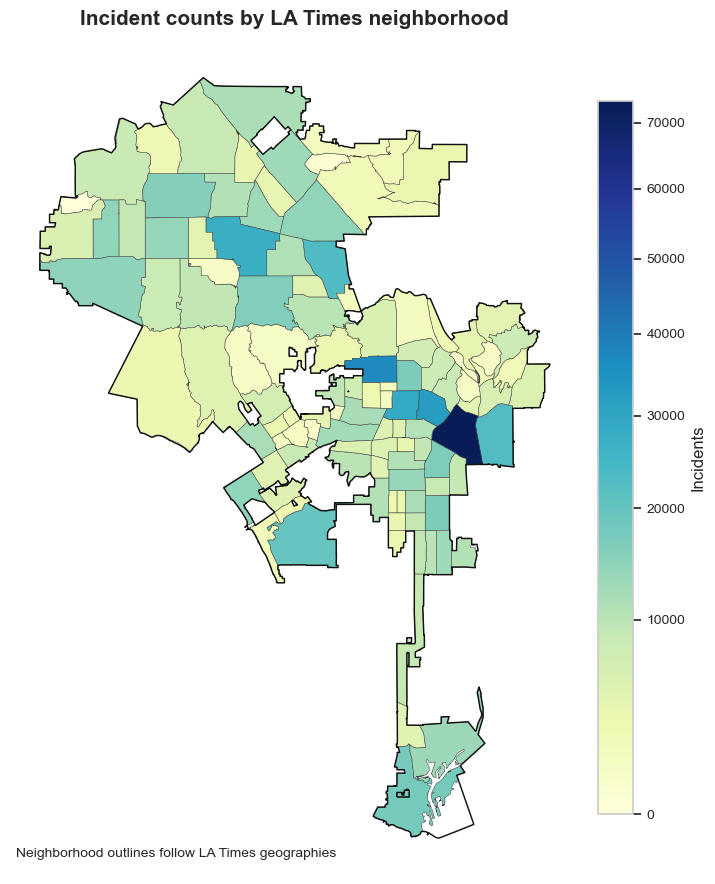

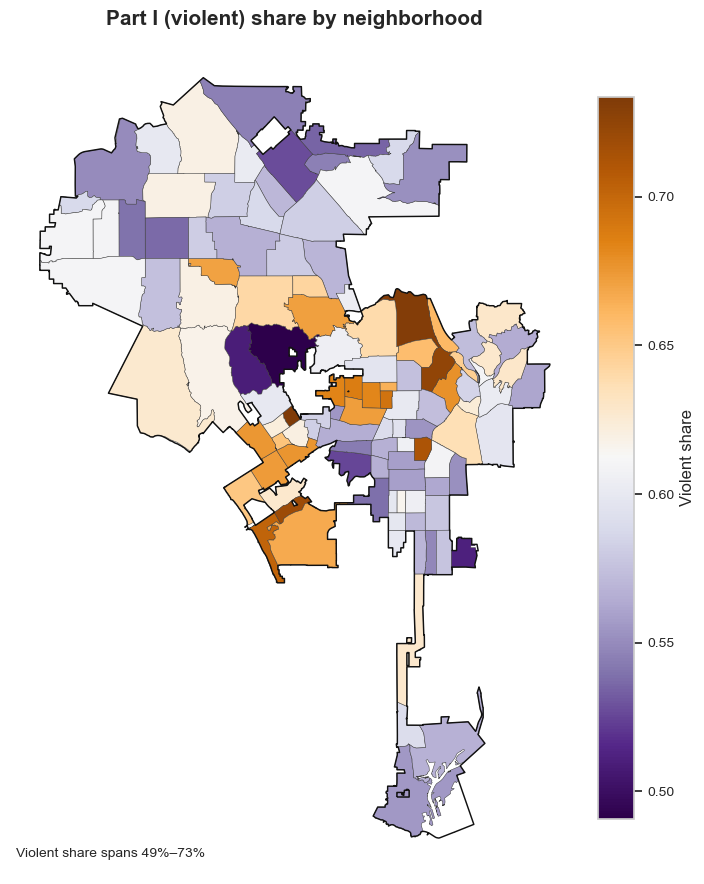

In [150]:
import geopandas as gpd
from matplotlib import colors
from pathlib import Path

neigh_path = Path("../Data/LA_Times_Neighborhood_Boundaries.geojson")
boundary_path = Path("../Data/City_Boundary.geojson")

neigh_shapes = (
    gpd.read_file(neigh_path)
    .to_crs(epsg=4326)[["name", "geometry"]]
    .rename(columns={"name": "neighborhood"})
)
neigh_shapes["neighborhood"] = neigh_shapes["neighborhood"].astype(str)
boundary = gpd.read_file(boundary_path).to_crs(epsg=4326)

incident_input = (
    df_clean[["DR_NO", "violent_crime", "weapon_present", "LAT", "LON"]]
    .dropna(subset=["LAT", "LON"])
    .copy()
)
incident_points = gpd.GeoDataFrame(
    incident_input[["DR_NO", "violent_crime", "weapon_present"]],
    geometry=gpd.points_from_xy(incident_input["LON"], incident_input["LAT"]),
    crs="EPSG:4326",
)

neigh_joined = gpd.sjoin(incident_points, neigh_shapes, how="inner", predicate="within")
if neigh_joined.empty:
    raise ValueError("No incidents intersected the provided neighborhood boundaries.")

neigh_summary = (
    neigh_joined.groupby("neighborhood")
    .agg(
        incidents=("DR_NO", "count"),
        violent_incidents=("violent_crime", "sum"),
        weapon_incidents=("weapon_present", "sum"),
    )
    .assign(
        violent_share=lambda d: d["violent_incidents"] / d["incidents"],
        weapon_share=lambda d: d["weapon_incidents"] / d["incidents"],
    )
    .reset_index()
)

neigh_map = neigh_shapes.merge(neigh_summary, on="neighborhood", how="left")
value_cols = ["incidents", "violent_incidents", "weapon_incidents", "violent_share", "weapon_share"]
neigh_map[value_cols] = neigh_map[value_cols].fillna(0)
neigh_data = neigh_map[neigh_map["incidents"] > 0].copy()
if neigh_data.empty:
    raise ValueError("Neighborhood GeoJSON produced zero aggregated incidents once merged.")

inc_norm = colors.PowerNorm(gamma=0.65, vmin=neigh_data["incidents"].min(), vmax=neigh_data["incidents"].max())
violent_norm = colors.Normalize(vmin=neigh_data["violent_share"].min(), vmax=neigh_data["violent_share"].max())
violent_min = neigh_data["violent_share"].min()
violent_max = neigh_data["violent_share"].max()
city_bounds = boundary.total_bounds


def plot_neighborhood_map(ax, gdf, column, cmap, norm, title, colorbar_label):
    outline = boundary.boundary
    gdf.plot(
        column=column,
        cmap=cmap,
        norm=norm,
        ax=ax,
        linewidth=0.35,
        edgecolor="#3b3b3b",
    )
    outline.plot(ax=ax, color="#111111", linewidth=1.05)
    ax.set_xlim(city_bounds[0] - 0.03, city_bounds[2] + 0.03)
    ax.set_ylim(city_bounds[1] - 0.03, city_bounds[3] + 0.03)
    ax.set_title(title, fontsize=15, pad=12)
    ax.axis("off")
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.02)
    cbar.set_label(colorbar_label, fontsize=12)
    cbar.ax.tick_params(labelsize=10)


fig1, ax1 = plt.subplots(figsize=(10, 9), subplot_kw={"aspect": "equal"})
plot_neighborhood_map(
    ax1,
    neigh_data,
    column="incidents",
    cmap="YlGnBu",
    norm=inc_norm,
    title="Incident counts by LA Times neighborhood",
    colorbar_label="Incidents",
)
ax1.text(
    0.01,
    0.02,
    "Neighborhood outlines follow LA Times geographies",
    transform=ax1.transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85),
)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(10, 9), subplot_kw={"aspect": "equal"})
plot_neighborhood_map(
    ax2,
    neigh_data,
    column="violent_share",
    cmap="PuOr_r",
    norm=violent_norm,
    title="Part I (violent) share by neighborhood",
    colorbar_label="Violent share",
)
ax2.text(
    0.01,
    0.02,
    f"Violent share spans {violent_min:.0%}–{violent_max:.0%}",
    transform=ax2.transAxes,
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85),
)
plt.tight_layout()
plt.show()


In [151]:
from IPython.display import display

neigh_display = (
    neigh_summary.sort_values("incidents", ascending=False)
    .head(15)
    .assign(
        violent_share=lambda d: (d["violent_share"] * 100).round(1),
        weapon_share=lambda d: (d["weapon_share"] * 100).round(1),
    )
    .rename(
        columns={
            "neighborhood": "Neighborhood",
            "violent_share": "violent_%",
            "weapon_share": "weapon_%",
        }
    )
)

display(neigh_display)


Neighborhood  incidents  violent_incidents  weapon_incidents  \
23                 Downtown      73361              46695             25979   
47                Hollywood      37173              22179             14781   
108                Westlake      32072              18409             13250   
52                Koreatown      28981              17398              9896   
97                 Van Nuys      27197              15408              8555   
67          North Hollywood      22978              13079              6693   
9             Boyle Heights      22866              13669              7783   
107             Westchester      19529              13029              5635   
80                San Pedro      17548               9753              5617   
33                 Florence      16700               9652              8072   
25           East Hollywood      16588               9535              6332   
46   Historic South-Central      16352               9952              6106   
84             Sherman Oaks      16174              10369              3091   
68               Northridge      15594               9660              4007   
113          Woodland Hills      14614               8909              3394   

     violent_%  weapon_%  
23        63.7      35.4  
47        59.7      39.8  
108       57.4      41.3  
52        60.0      34.1  
97        56.7      31.5  
67        56.9      29.1  
9         59.8      34.0  
107       66.7      28.9  
80        55.6      32.0  
33        57.8      48.3  
25        57.5      38.2  
46        60.9      37.3  
84        64.1      19.1  
68        61.9      25.7  
113       61.0      23.2